# Imports

In [1]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import cv2
import nibabel as nib
from celluloid import Camera
from IPython.display import HTML
from tqdm.notebook import tqdm

In [2]:
import imgaug
import imgaug.augmenters as iaa
from imgaug.augmentables.segmaps import SegmentationMapOnImage

import torch
import torch.nn as nn
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger

# Processing

In [3]:
root = Path("/media/hacen/3a0ab16a-82f1-416c-902d-3c782e61d1ec/medicaldecathlon//Task06_Lung/")
images_path = root/"imagesTr"
saving_path = Path("Processed")

In [4]:
def change_to_label_path(path):
    parts = list(path.parts)
    parts[parts.index('imagesTr')] = "labelsTr"
    
    return Path(*parts)

In [8]:
### Images Vizualition

In [17]:
len(list(images_path.glob('lu*')))

63

In [18]:
len(list(change_to_label_path(images_path).glob('lu*')))

63

In [36]:
example = list(images_path.glob('lu*'))[0]

In [37]:
example

PosixPath('/media/hacen/3a0ab16a-82f1-416c-902d-3c782e61d1ec/medicaldecathlon/Task06_Lung/imagesTr/lung_093.nii.gz')

In [38]:
slices = nib.load(example)
labels = nib.load(change_to_label_path(example)).get_fdata()

In [49]:
slices.get_fdata().min(), slices.get_fdata().max()

(-1024.0, 3071.0)

In [48]:
slices.get_fdata()[0].min(), slices.get_fdata()[0].max()

(-1024.0, 578.0)

In [34]:
labels.shape

(512, 512, 228)

In [35]:
nib.aff2axcodes(slices.affine)

('L', 'A', 'S')

#### Saggital slices

/home/hacen/anaconda3/envs/pytorchenv/lib/python3.7/site-packages/matplotlib/image.py:443: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/hacen/anaconda3/envs/pytorchenv/lib/python3.7/site-packages/matplotlib/image.py:444: UserWarning: Warning: converting a masked element to nan.
  vmid = np.float64(self.norm.vmin) + dv / 2


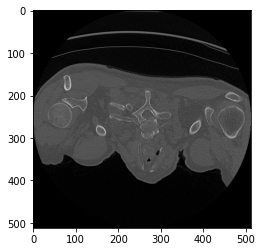

In [46]:
fig = plt.figure()
camera = Camera(fig)

for i in range(slices.shape[2]):
    slce = slices.get_fdata()[:, :, i]
    mask = labels.astype(np.uint8)
    
    mask = np.ma.masked_where(mask[:, :, i]==0, mask[:, :, i])
    
    plt.imshow(np.transpose(slce, (1, 0)), cmap='gray')
    plt.imshow(np.transpose(mask, (1, 0)), cmap='autumn', alpha=0.7)
    camera.snap()
    
animation = camera.animate()

In [45]:
HTML(animation.to_html5_video())

/home/hacen/anaconda3/envs/pytorchenv/lib/python3.7/site-packages/matplotlib/image.py:443: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/hacen/anaconda3/envs/pytorchenv/lib/python3.7/site-packages/matplotlib/image.py:444: UserWarning: Warning: converting a masked element to nan.
  vmid = np.float64(self.norm.vmin) + dv / 2


In [5]:
def normalize(volume):
    normalized = volume / 3071.0
    return normalized

### Preprocessing

In [59]:
for c, file_path in enumerate(tqdm(list(images_path.glob("lu*")))):
    volume = nib.load(file_path).get_fdata()
    labels = nib.load(change_to_label_path(file_path)).get_fdata().astype(np.uint8)
    
    images = normalize(volume)
    
    train_or_val = "train" if c < 50 else "val"
    
    current_image_path = saving_path/train_or_val/str(c)/'data'
    current_label_path = saving_path/train_or_val/str(c)/'masks'
    current_image_path.mkdir(parents=True, exist_ok=True)
    current_label_path.mkdir(parents=True, exist_ok=True)
    
    for i in range(images.shape[2]):
        slce = images[:, :, i]
        mask = labels[:, :, i]
        slce = cv2.resize(slce, (256, 256), interpolation=cv2.INTER_NEAREST)
        mask = cv2.resize(mask, (256, 256), interpolation=cv2.INTER_NEAREST)
        
        np.save(current_image_path/str(i), slce)
        np.save(current_label_path/str(i), mask)        

  0%|          | 0/63 [00:00<?, ?it/s]

# Dataset Model

In [6]:
class LungTumorDataset(torch.utils.data.Dataset):
    def __init__(self, path, augment_params):
        super().__init__()
        
        self.all_files = self.extract_files(path)
        self.augment_params = augment_params
        
    @staticmethod
    def extract_files(path):
        files = []
        
        for subject in path.glob("*"):
            slice_path = subject/'data'
            for slice_ in slice_path.glob("*.npy"):
                files.append(slice_)
                
        return files
    
    @staticmethod
    def change_to_label_path(path):
        parts = list(path.parts)
        parts[parts.index('data')] = "masks"

        return Path(*parts)
    
    def __len__(self):
        return len(self.all_files)
    
    def __getitem__(self, idx):
        file_path = self.all_files[idx]
        mask_path = self.change_to_label_path(file_path)
        
        slice_ = np.load(file_path).astype(np.float32)
        mask = np.load(mask_path)
        
        if self.augment_params:
            slice_, mask = self.augment(slice_, mask)
            
        return np.expand_dims(slice_, 0), np.expand_dims(mask, 0)
    
    def augment(self, slce, mask):
        random_seed = torch.randint(0, 100000, (1, )).item()
        imgaug.seed(random_seed)
        
        mask = SegmentationMapOnImage(mask, mask.shape)
        slice_aug, mask_aug = self.augment_params(image=slce, segmentation_maps=mask)
        mask_aug = mask_aug.get_arr()
        
        return slice_aug, mask_aug

In [7]:
aug_seq = iaa.Sequential([
        iaa.Affine(scale=(0.8, 1.2), rotate=(-45, 45)),
#         iaa.ElasticTransformation()
])

train_path = saving_path/'train'
val_path = saving_path/'val'

In [8]:
train_dataset = LungTumorDataset(train_path, aug_seq)
val_dataset = LungTumorDataset(val_path, None)

In [24]:
len(train_dataset), len(val_dataset)

(15420, 2237)

In [15]:
example = train_dataset[0]
example[0].shape

(1, 256, 256)

/home/hacen/anaconda3/envs/pytorchenv/lib/python3.7/site-packages/imgaug/imgaug.py:184: DeprecationWarning: Function `SegmentationMapOnImage()` is deprecated. Use `SegmentationMapsOnImage` instead. (Note the plural 'Maps' instead of old 'Map'.).
  warn_deprecated(msg, stacklevel=3)


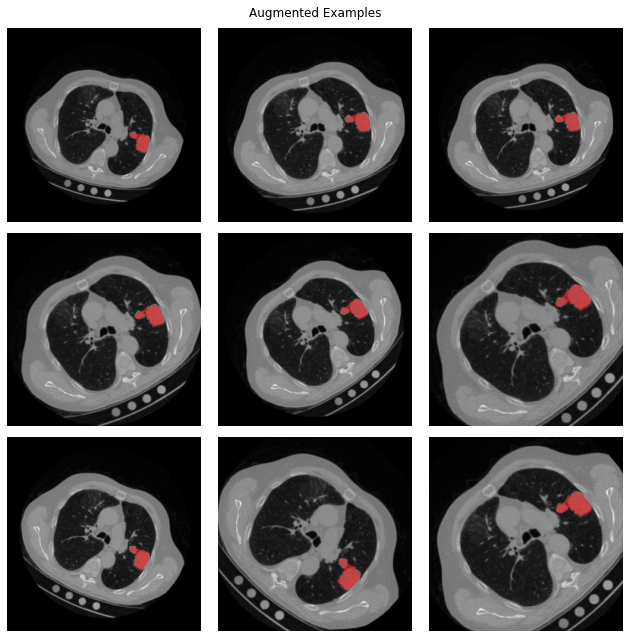

In [64]:
fig, axs = plt.subplots(3, 3, figsize=(9, 9))

for i in range(3):
    for j in range(3):
        image, mask = train_dataset[5]
        mask_ = np.ma.masked_where(mask==0, mask)
        
        axs[i][j].imshow(np.rot90(image[0]), cmap='gray')
        axs[i][j].imshow(np.rot90(mask_[0]), cmap='autumn', alpha=0.5)
        axs[i][j].axis('off')
        
plt.suptitle('Augmented Examples')
plt.tight_layout()

# Model Creation and Training

### Double Conv

In [9]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        self.step = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.ReLU()
        )
        
    def forward(self, X):
        return self.step(X)

### UNet

In [10]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.layer1 = DoubleConv(1, 64)
        self.layer2 = DoubleConv(64, 128)
        self.layer3 = DoubleConv(128, 256)
        self.layer4 = DoubleConv(256, 512)
        
        self.layer5 = DoubleConv(512+256, 256)
        self.layer6 = DoubleConv(256+128, 128)
        self.layer7 = DoubleConv(128+64, 64)
        self.layer8 = nn.Conv2d(64, 1, 1)
        
        self.maxpool = nn.MaxPool2d(2)
        
    def forward(self, x):
        
        x1 = self.layer1(x)
        x1m = self.maxpool(x1)
        
        x2 = self.layer2(x1m)
        x2m = self.maxpool(x2)
        
        x3 = self.layer3(x2m)
        x3m = self.maxpool(x3)
        
        x4 = self.layer4(x3m)
        
        x5 = nn.Upsample(scale_factor=2, mode='bilinear')(x4)
        x5 = torch.cat([x5, x3], dim=1)
        x5 = self.layer5(x5)
        
        x6 = nn.Upsample(scale_factor=2, mode='bilinear')(x5)
        x6 = torch.cat([x6, x2], dim=1)
        x6 = self.layer6(x6)
        
        x7 = nn.Upsample(scale_factor=2, mode='bilinear')(x6)
        x7 = torch.cat([x7, x1], dim=1)
        x7 = self.layer7(x7)
        
        x8 = self.layer8(x7)
        return x8

In [75]:
unet = UNet()

In [76]:
random_tensor = torch.randn(1, 1, 256, 256)
output = unet(random_tensor)
output.shape

torch.Size([1, 1, 256, 256])

### LungTumorModel

In [11]:
class LungTumorSegmentor(pl.LightningModule):
    def __init__(self):
        super().__init__()
        
        self.model = UNet()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
        self.loss_fn = nn.BCEWithLogitsLoss()
        
    def forward(self, data):
        return self.model(data)
        
    def training_step(self, batch, batch_idx):
        slce, mask = batch
        mask = mask.float()
        pred = self(slce)
        
        loss = self.loss_fn(pred, mask)
        
        self.log("Train Loss", loss)
        
        if batch_idx % 50 == 0:
            self.log_images(slce.cpu(), pred.cpu(), mask.cpu(), "Train")
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        slce, mask = batch
        mask = mask.float()
        pred = self(slce)
        
        loss = self.loss_fn(pred, mask)
        
        self.log("Val Loss", loss)
        
        if batch_idx % 50 == 0:
            self.log_images(slce.cpu(), pred.cpu(), mask.cpu(), "Val")
        
        return loss 
    
    def log_images(self, slce, pred, mask, name):
        pred = pred > 0.5
        
        fig, axs = plt.subplots(1, 2)
        axs[0].imshow(slce[0][0], cmap='bone')
        mask_ = np.ma.masked_where(mask==0, mask)
        axs[0].imshow(mask_[0][0], cmap='autumn', alpha=0.5)
        
        axs[1].imshow(slce[0][0], cmap='bone')
        mask_ = np.ma.masked_where(pred==0, pred)
        axs[1].imshow(mask_[0][0], cmap='autumn', alpha=0.5)
        
        self.logger.experiment.add_figure(name, fig, self.global_step)
        
    def configure_optimizers(self):
        return [self.optimizer]

In [28]:
torch.manual_seed(0)
model = LungTumorSegmentor()

In [29]:
collback_checkpoint = ModelCheckpoint(monitor="Val Loss", dirpath="checkpoints", 
                                      filename="{epoch}-{Val Loss:.2f}-{step:.2f}", mode='min')

In [30]:
trainer = pl.Trainer(gpus=1, logger=TensorBoardLogger('logs/'), callbacks=collback_checkpoint, max_epochs=10)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [31]:
batch_size = 8
num_workers = 4

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)

In [32]:
trainer.fit(model, train_loader, val_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type              | Params
----------------------------------------------
0 | model   | UNet              | 7.8 M 
1 | loss_fn | BCEWithLogitsLoss | 0     
----------------------------------------------
7.8 M     Trainable params
0         Non-trainable params
7.8 M     Total params
31.127    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/home/hacen/anaconda3/envs/pytorchenv/lib/python3.7/site-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/home/hacen/anaconda3/envs/pytorchenv/lib/python3.7/site-packages/matplotlib/image.py:443: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/hacen/anaconda3/envs/pytorchenv/lib/python3.7/site-packages/matplotlib/image.py:444: UserWarning: Warning: converting a masked element to nan.
  vmid = np.float64(self.norm.vmin) + dv / 2


Training: -1it [00:00, ?it/s]

/home/hacen/anaconda3/envs/pytorchenv/lib/python3.7/site-packages/imgaug/imgaug.py:184: DeprecationWarning: Function `SegmentationMapOnImage()` is deprecated. Use `SegmentationMapsOnImage` instead. (Note the plural 'Maps' instead of old 'Map'.).
  warn_deprecated(msg, stacklevel=3)
/home/hacen/anaconda3/envs/pytorchenv/lib/python3.7/site-packages/imgaug/imgaug.py:184: DeprecationWarning: Function `SegmentationMapOnImage()` is deprecated. Use `SegmentationMapsOnImage` instead. (Note the plural 'Maps' instead of old 'Map'.).
  warn_deprecated(msg, stacklevel=3)
/home/hacen/anaconda3/envs/pytorchenv/lib/python3.7/site-packages/imgaug/imgaug.py:184: DeprecationWarning: Function `SegmentationMapOnImage()` is deprecated. Use `SegmentationMapsOnImage` instead. (Note the plural 'Maps' instead of old 'Map'.).
  warn_deprecated(msg, stacklevel=3)
/home/hacen/anaconda3/envs/pytorchenv/lib/python3.7/site-packages/imgaug/imgaug.py:184: DeprecationWarning: Function `SegmentationMapOnImage()` is depr

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = LungTumorSegmentor.load_from_checkpoint('epoch=29-step=53759.ckpt')
model.eval();
model.to(device);

In [17]:
preds = []
labels = []

for slce, mask in tqdm(val_dataset):
    with torch.no_grad():
        pred = model(torch.tensor(slce.squeeze(0).to(device))
    
    labels.append(mask.cpu())
    preds.append(pred.cpu())

  0%|          | 0/3184 [00:00<?, ?it/s]

AttributeError: 'numpy.ndarray' object has no attribute 'to'